In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
artists_df = pd.read_csv('/content/artists.csv')
institutions_df = pd.read_csv('/content/institutions.csv')
relationships_df = pd.read_csv('/content/relationships.csv')
schools_df = pd.read_csv('/content/schools.csv')

In [10]:
art_col= list(artists_df.columns)
int_col= list(institutions_df.columns)
rel_col= list(relationships_df.columns)
school_col= list(schools_df.columns)
print(art_col)
print(int_col)
print(rel_col)
print(school_col)

['artistUrl', 'id', 'image', 'nation', 'title', 'totalWorksTitle', 'year']
['city', 'country', 'title', 'url']
['artistUrl', 'friends', 'influenced_by', 'influenced_on', 'institution', 'movements', 'school', 'type']
['title', 'url']


In [3]:
print("Missing values in artists.csv:")
print(artists_df.isnull().sum())

print("\nMissing values in relationships.csv:")
print(relationships_df.isnull().sum())

print("\nMissing values in institution.csv:")
print(institutions_df.isnull().sum())

print("\nMissing values in schools.csv:")
print(schools_df.isnull().sum())

Missing values in artists.csv:
artistUrl           0
id                  0
image               0
nation             32
title               0
totalWorksTitle     0
year                1
dtype: int64

Missing values in relationships.csv:
artistUrl           0
friends          2580
influenced_by    2512
influenced_on    2637
institution      2362
movements          40
school           1966
type                1
dtype: int64

Missing values in institution.csv:
city       2
country    2
title      0
url        0
dtype: int64

Missing values in schools.csv:
title    0
url      0
dtype: int64


In [5]:
artists_df['nation'].fillna('N/A', inplace=True)
artists_df['year'].fillna('N/A', inplace=True)

institutions_df['city'].fillna('N/A', inplace=True)
institutions_df['country'].fillna('N/A', inplace=True)

relationships_df['friends'] = relationships_df['friends'].fillna('')
relationships_df['influenced_by'] = relationships_df['influenced_by'].fillna('')
relationships_df['influenced_on'] = relationships_df['influenced_on'].fillna('')
relationships_df['institution'] = relationships_df['institution'].fillna('')
relationships_df['school'] = relationships_df['school'].fillna('')

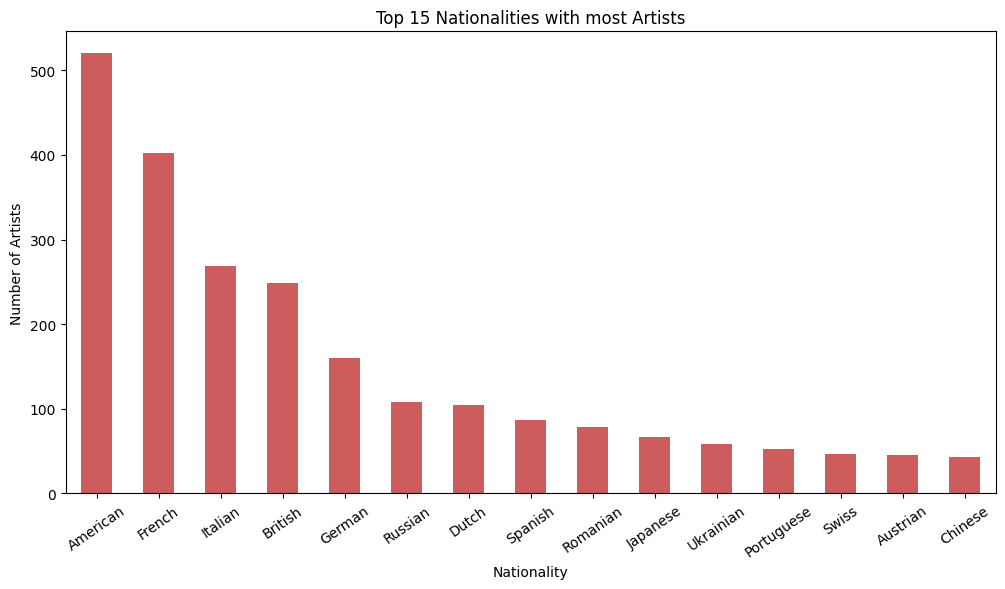

In [26]:
# Number of artists per nationality
plt.figure(figsize=(12, 6))
artists_df['nation'].value_counts().head(15).plot(kind='bar', title='Top 15 Nationalities with most Artists', color='indianred')
plt.xlabel('Nationality')
plt.ylabel('Number of Artists')
plt.xticks(rotation=35)
plt.show()

In [49]:
import networkx as nx
import ast
from networkx.algorithms.community import greedy_modularity_communities
G = nx.DiGraph()

for _, row in relationships_df.iterrows():
    artist = row['artistUrl']

    if artist not in G:
        G.add_node(artist, type='artist')

    if pd.notnull(row['influenced_by']):
        influenced_by_list = row['influenced_by'].split(',')
        for influence in influenced_by_list:
            influence = influence.strip()

            if 'artists-by-art-movement' in influence:
                if influence not in G:
                    G.add_node(influence, type='movement')
                G.add_edge(influence, artist, relationship='influenced_by')
            elif 'artists-by-painting-school' in influence:
                if influence not in G:
                    G.add_node(influence, type='school')
                G.add_edge(influence, artist, relationship='influenced_by')
            else:
                if influence not in G:
                    G.add_node(influence, type='artist')
                G.add_edge(influence, artist, relationship='influenced_by')

    if pd.notnull(row['influenced_on']):
        influenced_on_list = row['influenced_on'].split(',')
        for influenced_entry in influenced_on_list:
            influenced_entry = influenced_entry.strip()
            if 'artists-by-art-movement' in influenced_entry:
                if influenced_entry not in G:
                    G.add_node(influenced_entry, type='movement')
                G.add_edge(artist, influenced_entry, relationship='influences')
            elif 'artists-by-painting-school' in influenced_entry:
                if influenced_entry not in G:
                    G.add_node(influenced_entry, type='school')
                G.add_edge(artist, influenced_entry, relationship='influences')
            else:
                if influenced_entry not in G:
                    G.add_node(influenced_entry, type='artist')
                G.add_edge(artist, influenced_entry, relationship='influences')

    if pd.notnull(row['institution']):
        institutions_list = row['institution'].split(',')
        for institution in institutions_list:
            institution = institution.strip()
            if institution not in G:
                G.add_node(institution, type='institution')
            G.add_edge(institution, artist, relationship='affiliated_with')

print("Graph constructed with", G.number_of_nodes(), "nodes and", G.number_of_edges(), "edges.")

Graph constructed with 3227 nodes and 7629 edges.


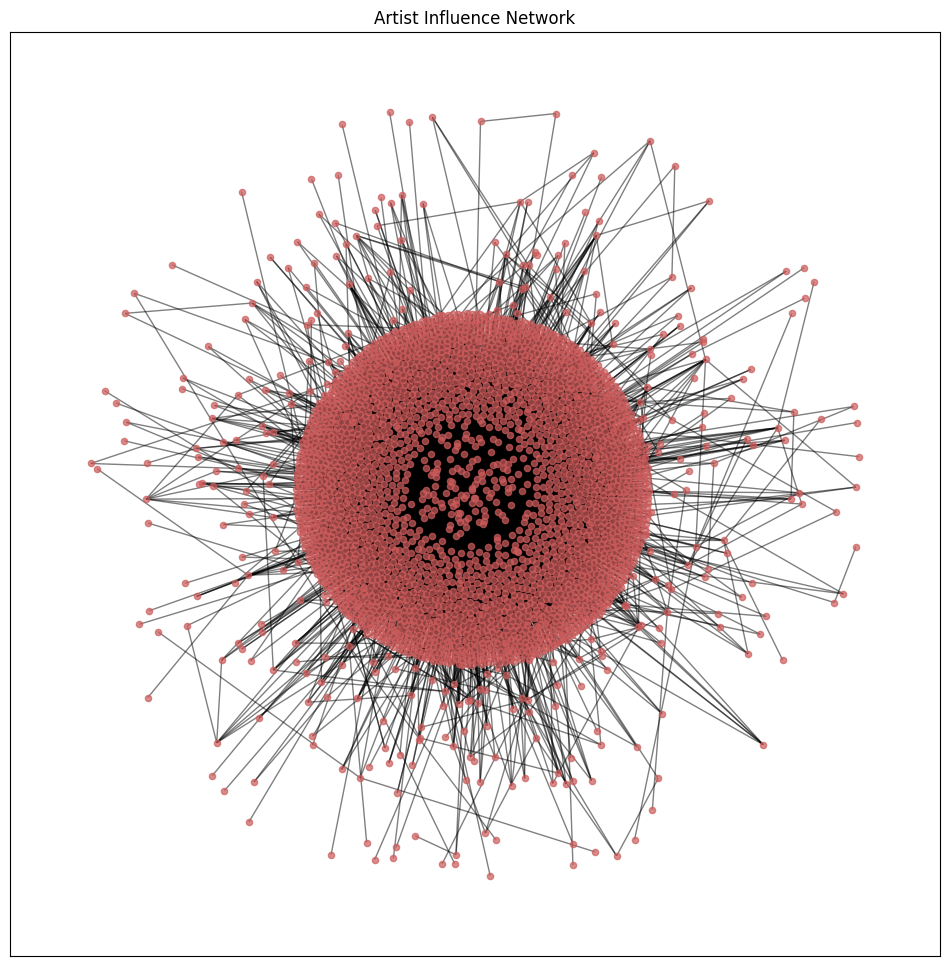

In [42]:
plt.figure(figsize=(12, 12))
largest_cc = max(nx.weakly_connected_components(G), key=len)
H = G.subgraph(largest_cc)
pos = nx.spring_layout(H, k=0.1)
nx.draw_networkx_nodes(H, pos, node_size=20, node_color='indianred', alpha=0.7)
nx.draw_networkx_edges(H, pos, arrows=False, alpha=0.5)
plt.title('Artist Influence Network')
plt.show()

In [47]:
from networkx.algorithms.community import greedy_modularity_communities
artist_influence_count = sorted([(node, len(G[node])) for node in G if G.nodes[node]['type'] == 'artist'],
                                key=lambda x: x[1], reverse=True)[:10]
print("Most Influential Artists:", artist_influence_count)

institution_centrality = sorted([(node, nx.degree_centrality(G)[node]) for node in G if G.nodes[node]['type'] == 'institution'],
                                key=lambda x: x[1], reverse=True)[:10]
print("Most Influential Institutions:", institution_centrality)

artists_df = pd.read_csv('/content/artists.csv')
top_nationalities = artists_df['nation'].value_counts().head(10)
print("Top 10 Nationalities by Artist Count:\n", top_nationalities)

communities = list(greedy_modularity_communities(G.to_undirected()))
largest_communities = sorted(communities, key=len, reverse=True)
print("Largest Community Size:", len(largest_communities[0]))
print("Sample of Largest Community Members:", list(largest_communities[0])[:10])

Most Influential Artists: [('/en/pablo-picasso', 25), ('/en/paul-cezanne', 23), ('/en/caravaggio', 21), ('/en/rembrandt', 21), ('/en/titian', 17), ('/en/gustave-courbet', 17), ('/en/nicolas-poussin', 16), ('/en/diego-velazquez', 16), ('/en/michelangelo', 15), ('/en/raphael', 15)]
Most Influential Institutions: [('', 1.6732796032238064), ('/en/artists-by-art-institution/cole-des-beaux-arts', 0.025108493490390574), ('/en/artists-by-art-institution/acad-mie-julian', 0.01642901425914445), ('/en/artists-by-art-institution/art-students-league', 0.015809051456912585), ('/en/artists-by-art-institution/akademie-der', 0.011159330440173589), ('/en/artists-by-art-institution/imperial-academy-of-arts-saint-petersburg-russia', 0.010849349039057656), ('/en/artists-by-art-institution/guild-of-saint-luke', 0.009609423434593924), ('/en/artists-by-art-institution/royal-academy-of', 0.008989460632362058), ('/en/artists-by-art-institution/national-academy', 0.008059516429014259), ('/en/artists-by-art-insti

In [45]:
movement_influence_count = sorted([(node, len(G[node])) for node in G if G.nodes[node]['type'] == 'movement'],
                                  key=lambda x: x[1], reverse=True)[:10]
print("Most Influential Movements:", movement_influence_count)

Most Influential Movements: [('/en/artists-by-art-movement/cubism', 11), ('/en/artists-by-art-movement/byzantine-art', 9), ('/en/artists-by-art-movement/expressionism', 6), ('/en/artists-by-art-movement/surrealism', 6), ('/en/artists-by-art-movement/impressionism', 5), ('/en/artists-by-art-movement/dada', 5), ('/en/artists-by-art-movement/gothic-art', 3), ('/en/artists-by-art-movement/post-impressionism', 3), ('/en/artists-by-art-movement/dutch-golden-age', 3), ('/en/artists-by-art-movement/native-art', 3)]


Top 5 nodes by degree centrality:
Node: , Type: institution, Centrality: 1.6733
Node: /en/artists-by-art-institution/cole-des-beaux-arts, Type: institution, Centrality: 0.0251
Node: /en/artists-by-art-institution/acad-mie-julian, Type: institution, Centrality: 0.0164
Node: /en/artists-by-art-institution/art-students-league, Type: institution, Centrality: 0.0158
Node: /en/pablo-picasso, Type: artist, Centrality: 0.0127

Top 5 nodes by betweenness centrality:
Node: , Type: institution, Centrality: 0.9291
Node: /en/paul-cezanne, Type: artist, Centrality: 0.0077
Node: /en/gustave-courbet, Type: artist, Centrality: 0.0049
Node: /en/orthodox-icons, Type: artist, Centrality: 0.0036
Node: /en/robert-delaunay, Type: artist, Centrality: 0.0035

Top 5 nodes by PageRank:
Node: , Type: institution, PageRank: 0.4135
Node: /en/ancient-greek-painting, Type: artist, PageRank: 0.0011
Node: /en/charles-gibbons, Type: artist, PageRank: 0.0008
Node: /en/paul-nash, Type: artist, PageRank: 0.0008
Node: /en/d

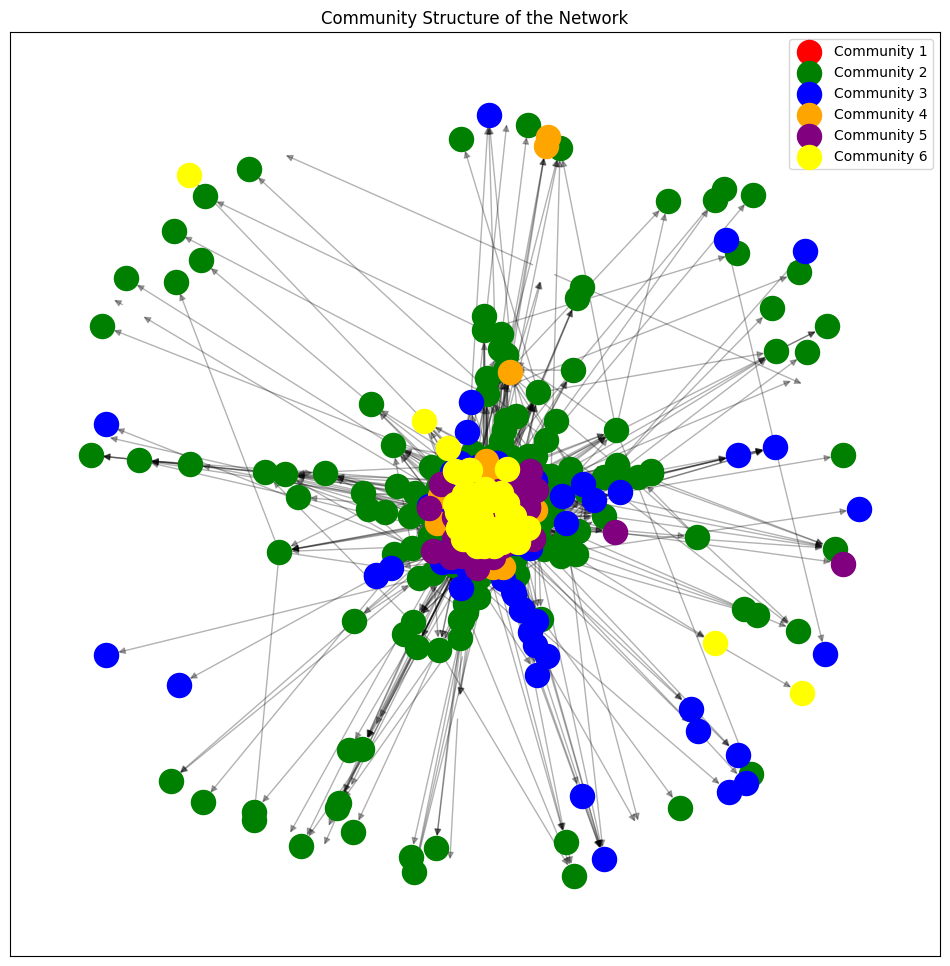

In [48]:
import networkx as nx

# 1. Degree Centrality
degree_centrality = nx.degree_centrality(G)
sorted_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)

# Print the top 5 nodes by degree centrality
print("Top 5 nodes by degree centrality:")
for node, centrality in sorted_degree[:5]:
    print(f"Node: {node}, Type: {G.nodes[node]['type']}, Centrality: {centrality:.4f}")

# 2. Betweenness Centrality
betweenness_centrality = nx.betweenness_centrality(G)
sorted_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)

# Print the top 5 nodes by betweenness centrality
print("\nTop 5 nodes by betweenness centrality:")
for node, centrality in sorted_betweenness[:5]:
    print(f"Node: {node}, Type: {G.nodes[node]['type']}, Centrality: {centrality:.4f}")

# 3. PageRank
pagerank = nx.pagerank(G)
sorted_pagerank = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)

# Print the top 5 nodes by PageRank
print("\nTop 5 nodes by PageRank:")
for node, rank in sorted_pagerank[:5]:
    print(f"Node: {node}, Type: {G.nodes[node]['type']}, PageRank: {rank:.4f}")

# 4. Community Detection
from networkx.algorithms.community import greedy_modularity_communities

communities = list(greedy_modularity_communities(G))
print("\nNumber of communities detected:", len(communities))

# Print the size of the largest community
largest_community = max(communities, key=len)
print("Size of the largest community:", len(largest_community))

# 5. Clustering Coefficient
# Average clustering coefficient of the whole graph
average_clustering = nx.average_clustering(G.to_undirected())
print("\nAverage clustering coefficient of the network:", average_clustering)

# Clustering coefficient for individual nodes
node_clustering = nx.clustering(G.to_undirected())

# Print the top 5 nodes by clustering coefficient
sorted_clustering = sorted(node_clustering.items(), key=lambda x: x[1], reverse=True)
print("\nTop 5 nodes by clustering coefficient:")
for node, coefficient in sorted_clustering[:5]:
    print(f"Node: {node}, Type: {G.nodes[node]['type']}, Clustering Coefficient: {coefficient:.4f}")

# Visualizing the community structure (optional)
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G)
colors = ['red', 'green', 'blue', 'orange', 'purple', 'yellow']

for i, community in enumerate(communities[:len(colors)]):  # Limit to the first few colors for visualization
    nx.draw_networkx_nodes(G, pos, nodelist=community, node_color=colors[i % len(colors)], label=f'Community {i+1}')

nx.draw_networkx_edges(G, pos, alpha=0.3)
plt.title("Community Structure of the Network")
plt.legend()
plt.show()